
# ECE324 - Assessment 1

This assessment consists of four exercises designed to evaluate your understanding of key concepts in neural network engineering. Please complete all exercises in this Jupyter Notebook.
Code quality will not be graded, however, clear and functional code is necessary for us to provide meaningful feedback.
Ensure your code is well-commented and explanations are concise and scientifically grounded.
Avoid hyperbole and anthropomorphic language.

Turn in your notebook as **'{first_name}{lastname_inital_caps}_assessment1.ipynb'**, for example your instructor would upload **benjaminS_assessment1.ipynb**


## Libraries

Only use these libraries:

In [80]:
# In colab:
!pip install jaxtyping torchinfo

In [81]:
import jaxtyping
from jaxtyping import Float, Array
import tqdm.auto as tqdm
import IPython.display as ipy_display

# Scientific python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.spatial.distance as sp_dist
import sklearn.neighbors
import sklearn.metrics
import sklearn.decomposition

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchinfo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Exercise 1: Geometric Properties of High Dimensional Spaces (2 pts)

This exercise aims to build your intuition regarding the geometry of high-dimensional spaces, which are frequently encountered in deep learning, particularly in the context of latent representations. We will explore properties of randomly generated vectors drawn from a normal Gaussian distribution as dimensionality increases.

Inspired on: ["On the Surprising Behavior of Distance Metrics in High Dimensional Space"](https://link.springer.com/chapter/10.1007/3-540-44503-X_27).

**Tips**:

* Use `plt.xscale('log')` for plots that use dimensions on the xaxis.
* `dict` is good to collect indivdual results.
* `pd.Dataframe(list[dict])` is good for building a table of results.
*  `sklearn.neighbors` has a fast approximate nearest neighbor algorithm.
*  Additional plots (histograms) can be useful to build better intuition but not required for an answer.


### Constants (do not edit)

In [105]:
dimensions = [2, 5, 10, 25 ,50, 100, 250, 500, 1000]
num_vectors = 1000
num_trials = 10 # For stochastic exercises

### 1.a Vector norms (.25 pts)

For each vector dimension:
* Generate sets of random vectors of dimenionality=dimension.
* For each dimension, generate `num_vectors` vectors sampled from a standard normal Gaussian distribution ($\mathcal{N}(0, \mathbf{I})$).
* Calculate the norms of these vectors and compute the mean and standard deviation of these norms.

**Expected output:** Plot of `Dimension` vs `Mean Norm` with errorbars or shaded width using the std.

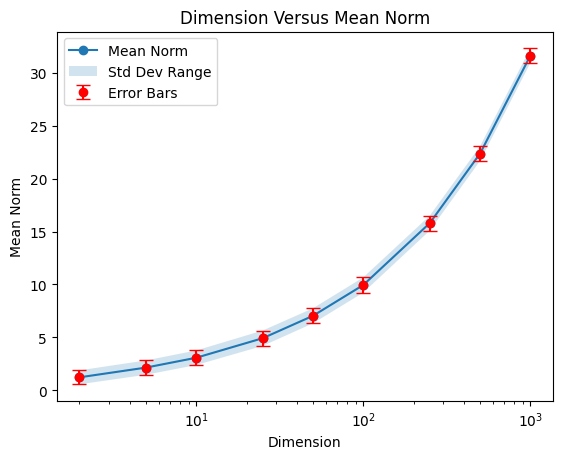

In [106]:
mean_norms = []
standard_deviations = []
for dim in dimensions:
    vectors = torch.randn(num_vectors, dim, device=device)
    norms = torch.norm(vectors, dim=1)
    mean_norms.append(norms.mean().item())
    standard_deviations.append(norms.std().item())

mean_norms = np.array(mean_norms)
standard_deviations = np.array(standard_deviations)

plt.figure()
plt.plot(dimensions, mean_norms, label="Mean Norm", marker='o', linestyle='-', markersize=6)
plt.fill_between(dimensions, mean_norms - standard_deviations, mean_norms + standard_deviations, alpha=0.2, label="Std Dev Range")
plt.errorbar(dimensions, mean_norms, yerr=standard_deviations, fmt='o', capsize=5, color='red', label="Error Bars")
plt.legend()
plt.title('Dimension Versus Mean Norm')
plt.ylabel('Mean Norm')
plt.xlabel('Dimension')
plt.xscale('log')
plt.show()
plt.close()



### 1.b Pairwise distances (.25 pts)

For each dimension in `dimensions`:
* Generate random vectors.
* Calculate pairwise Euclidean and Cosine distances between all generated vectors.
* Compute the mean and standard deviation of these pairwise distances for both metrics.

**Expected output:** Plot of `Dimension` vs `Average Pairwise` with errorbars or shaded width using the std. One for each metric.


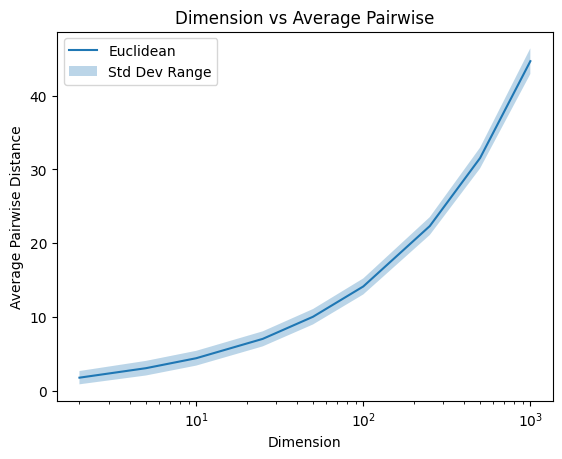

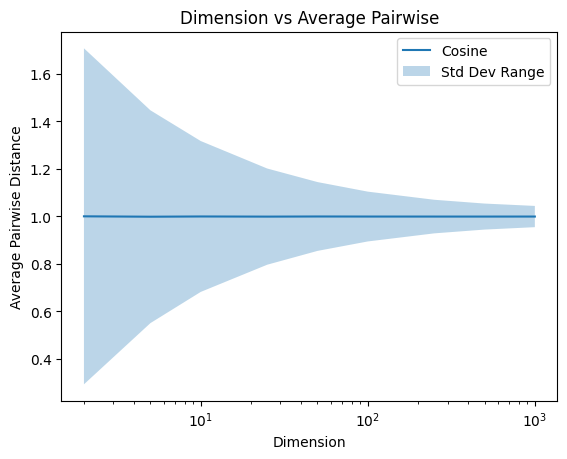

In [107]:
avg_pw_euclidean = []
avg_pw_cosine = []
mean_euclidean = []
mean_cosine = []
standard_deviations_euclidean = []
standard_deviations_cosine = []

for dim in dimensions:
    vectors = torch.randn(size=(num_vectors, dim)).numpy()

    e_dist = sp_dist.pdist(vectors, metric='euclidean')
    e_dist = sp_dist.squareform(e_dist)
    e_mean = np.mean(e_dist)
    e_std = np.std(e_dist)

    c_dist = sp_dist.pdist(vectors, metric='cosine')
    c_dist = sp_dist.squareform(c_dist)
    c_mean = np.mean(c_dist)
    c_std = np.std(c_dist)


    avg_pw_euclidean.append(e_mean)
    avg_pw_cosine.append(c_mean)
    standard_deviations_euclidean.append(e_std)
    standard_deviations_cosine.append(c_std)

avg_pw_euclidean = np.array(avg_pw_euclidean)
avg_pw_cosine = np.array(avg_pw_cosine)
standard_deviations_euclidean = np.array(standard_deviations_euclidean)
standard_deviations_cosine = np.array(standard_deviations_cosine)


plt.figure()
plt.plot(dimensions, avg_pw_euclidean, label='Euclidean')
plt.fill_between(dimensions, avg_pw_euclidean - standard_deviations_euclidean, avg_pw_euclidean + standard_deviations_euclidean, alpha=0.3, label='Std Dev Range')
plt.legend()
plt.title('Dimension vs Average Pairwise')
plt.ylabel('Average Pairwise Distance')
plt.xlabel('Dimension')
plt.xscale('log')
plt.show()
plt.close()

plt.figure()
plt.plot(dimensions, avg_pw_cosine, label='Cosine')
plt.fill_between(dimensions, avg_pw_cosine - standard_deviations_cosine, avg_pw_cosine + standard_deviations_cosine, alpha=0.3, label='Std Dev Range')
plt.legend()
plt.title('Dimension vs Average Pairwise')
plt.ylabel('Average Pairwise Distance')
plt.xlabel('Dimension')
plt.xscale('log')
plt.show()
plt.close()



### 1.c Angle Between Random Vectors (.25 pts)

Investigate how the distribution of angles between pairs of randomly generated vectors changes as dimensionality increases.

For each dimension in dimensions:
* Generate `num_vectors` pairs of random vectors.
* Calculate the angle (in degrees) between each pair of vectors.
* Decide if the vectors are "close to orthogonal" (+/- 10 degrees from 90)

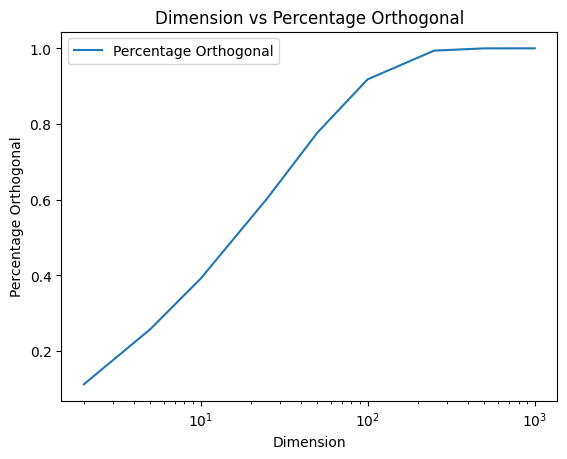

In [108]:
pct_orthogonal = []

for dim in dimensions:
    vectors = torch.randn(size=(num_vectors, dim)).numpy()

    c_dist = 1- sp_dist.pdist(vectors, metric='cosine') # \cos\theta
    c_dist = np.arccos(np.clip(c_dist, -1.0, 1.0)) # arccos
    c_dist = np.degrees(c_dist)

    orthogonal = np.where((c_dist >= 80) & (c_dist <= 100), 1, 0)
    pct_orthogonal.append(np.mean(orthogonal))

pct_orthogonal = np.array(pct_orthogonal)

plt.figure()
plt.plot(dimensions, pct_orthogonal, label='Percentage Orthogonal')
plt.legend()
plt.title('Dimension vs Percentage Orthogonal')
plt.ylabel('Percentage Orthogonal')
plt.xlabel('Dimension')
plt.xscale('log')
plt.show()
plt.close()



### 1.d Nearest Neighbors (.25 pts)


For each dimension in dimensions, and for num_trials trials:
* Generate a random query vector.
* Find its 5 nearest neighbors within the set of num_vectors generated vectors.
* Record the distances (euclidean, cosine) to the first nearest neighbor.
* Compute the average and standard deviation of these distances across trials for each dimension and metric.

**Expected output:** Plot of `Dimension` vs `Distance to nearest neighbor` with errorbars or shaded width using the std. One for each metric.

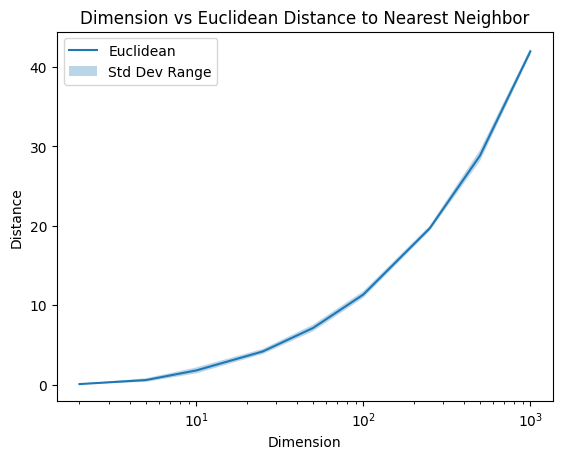

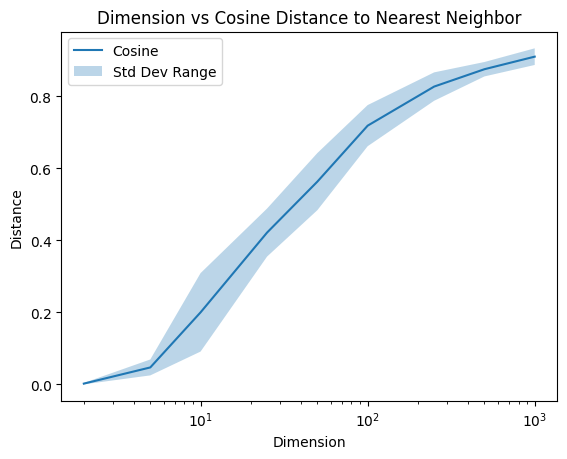

In [ ]:

mean_euclidean = []
mean_cosine = []
std_euclidean = []
std_cosine = []

for dim in dimensions:
    euclidean_distances = []
    cosine_distances = []

    for trial in range(num_trials):
        vectors = torch.randn(size=(num_vectors, dim))
        query_vector = torch.randn((1, dim))

        NN = sklearn.neighbors.NearestNeighbors(n_neighbors=5, algorithm='auto').fit(vectors)
        distances, indices = NN.kneighbors(query_vector, n_neighbors=5, return_distance=True)

        first_nn = vectors[indices[0, 0]]
        cosine_distance = 1 - torch.nn.functional.cosine_similarity(query_vector, first_nn.unsqueeze(0))

        euclidean_distances.append(distances[0][0])
        cosine_distances.append(cosine_distance.item())

    euclidean_distances = np.array(euclidean_distances)
    cosine_distances = np.array(cosine_distances)

    mean_euclidean.append(np.mean(euclidean_distances))
    mean_cosine.append(np.mean(cosine_distances))
    std_euclidean.append(np.std(euclidean_distances))
    std_cosine.append(np.std(cosine_distances))

mean_euclidean = np.array(mean_euclidean)
mean_cosine = np.array(mean_cosine)
std_euclidean = np.array(std_euclidean)
std_cosine = np.array(std_cosine)

# Plot Euclidean distances
plt.figure()
plt.plot(dimensions, mean_euclidean, label='Euclidean')
plt.fill_between(dimensions, mean_euclidean - std_euclidean, mean_euclidean + std_euclidean, alpha=0.3, label='Std Dev Range')
plt.legend()
plt.title('Dimension vs Euclidean Distance to Nearest Neighbor')
plt.ylabel('Distance')
plt.xlabel('Dimension')
plt.xscale('log')
plt.show()

# Plot Cosine distances
plt.figure()
plt.plot(dimensions, mean_cosine, label='Cosine')
plt.fill_between(dimensions, mean_cosine - std_cosine, mean_cosine + std_cosine, alpha=0.3, label='Std Dev Range')
plt.legend()
plt.title('Dimension vs Cosine Distance to Nearest Neighbor')
plt.ylabel('Distance')
plt.xlabel('Dimension')
plt.xscale('log')
plt.show()

### 1.e Summarize and reflect on the results (1 pts)

Summarize the results from previous exercises, make reference to the plots when making your points. You should reference at least once each plot in your writting.

Some questions you will want to address:

* We generated random normal distributed vectors, is this a reasonable assumption when working neural network activations? *
* Why? When does this assumption break?
* What can you intuite about the "data manifold" (learned geometry of data)?
* If you wanted to interpolate between two vector, where the path lies close to data, how would you do it?
* How probable are zero-vectors?
* Which distance would you use? (and why?)


* We generated random normal distributed vectors, is this a reasonable assumption when working neural network activations? *

This is a reasonable assumption when working with NN activations. tanh in particular supports this the most. \\

* Why? When does this assumption break?

The plot in part 1.a shows that the norm of Gaussian-distributed vectors scales as $\sqrt{d}$ which suggests that if NN activations were Gaussian, their norms would behave like so. However, activation functions like ReLU and Sigmoid skew the values and introduce saturated units. This breaks the gaussian assumption and lads to distributions deviating from pure Gaussian behavior.

* What can you intuite about the "data manifold" (learned geometry of data)?

The data manifold refers to the useful features of the data, which often is far lower in dimensions compared to the original data. This can be seen as a kind of noise and the learning is a denoising step. We can intuit a far smaller dimension space as the data manifold and wherein slight changes might create large differences. We also can assume some kind of continuity in this space which supports clustering of similar samples. Orthgonality and parlel vectors in this space reveal key features of the data.
* If you wanted to interpolate between two vector, where the path lies close to data, how would you do it?

We could use pca to project the vectors on their principal components and interpolate on them. This allwos us to ensure the path stays within the data's variance range. Additionaly, we could use flow matching.
* How probable are zero-vectors?

From plot 1.a, we see that in all our sampling, the mean norm was always positive and increased with dimension. This indicates that getting a 0 vector is inprobable and gets more difficult with increasing dimensions.
* Which distance would you use? (and why?)

I think both distances have thier own use cases. Cosine distance helps perserve direction as well as size, while euclidean is rather invariant to direction. For such cases where direction is imporant, we might prefer cosine. Additionally, i think cosine perfroms better for sparse data as euclidean will be very low even if it points in different directions. Conversely, euclidean will be better for dense vectors as it can catch the details while cosine will likely become no corelation. As is seen in plot 1.d.


The above exercises reveal some differences between cosine and euclidean distances. PLot 1.b shows that the euclidean distance between a set of points is well correlated to its dimension and does not deviate too much. It grows at a rate of $\sqrt{d}$. The cosine plot shows that the mean distance is consistenly 1, implying that the data points are orthogonal to one another, on average. An interesting pattern we observe is that at smaller dimensions, the standard deviation is greater and there are cosine distances from 1.6 to 0.2. As dimension increases, this variance decreases and more points are closer to 1. This means there is no corelation between the vectors, as expected.

Plot 1.c shows that as you increase dimension, the percentage of orthoganal vectors increases. This makes sense as greater dimensions allow for more degrees where the vectors can be orthogonal in. Another phrasing is that more dimensions requrie more aligned dimensions in order to prevent orthogonality.

Plot 1.d shows the trend of distance of both euclidean and cosine distances. The euclidean distances demonstrate that as you get more dimensions, the nearest neighbour gets further and further away. The cosine distance shows this but with less utility as the nearest distance is orthogonal. This makes me think that cosine distance when dim is large is not the best metric.

## Exercise 2: VAE to β-VAE (2 pts)

This exercise extends the Variational Autoencoder (VAE) to a Beta-VAE (β-VAE). The β-VAE introduces a hyperparameter, β, to control the weight of the KL divergence term in the loss function. By varying β, we can influence the properties of the learned latent space, specifically its degree of disentanglement

Based on ["β-VAE: Learning Basic Visual Concepts with a Constrained Variational Framework, ICLR, 2017"](https://openreview.net/pdf?id=Sy2fzU9gl)

If you want to read more: ["Understanding disentangling in β-VAE, NeurIPS '17"](https://arxiv.org/pdf/1804.03599).

Things to do:
* Define a CNN-VAE, we have already seen a MLP-VAE in codelab 3 and CNNs in codelab 4.
* Modify the VAE loss function to include beta.
* Train multiple β-VAEs for `beta=[0, 1.0, 5.0, 25.0]` with latent dimension `10`.
* For each model collect test latent representations, their 2D PCA reduced version and their **silhouette_score** (sklearn.metrics) with the test labels.
* Plot their 2D latent representation color coded by labels, report scores.


**Expected output:** code and plots.


### Sample code to use


In [109]:
latent_dim = 10
batch_size = 1024
learning_rate = 1e-3
epochs = 10
beta_values = [0, 1.0, 5.0, 25]

In [110]:
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Your model and loss_fn code here (.5pt)

*   List item
*   List item



In [129]:
class CNN_VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(CNN_VAE, self).__init__()

        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),   # 28*28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                     # 14x14
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # 14*14
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                                     # 7*7
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(32*7*7, latent_dim)
        self.fc_logvar = nn.Linear(32*7*7, latent_dim)

        self.dec_fc = nn.Linear(latent_dim, 32*7*7)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14*14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 28*28
            nn.Sigmoid()
        )


    def encode(self, x):
        h = self.enc(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.dec_fc(z).view(-1, 32, 7, 7)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        pred = self.decode(self.reparameterize(mu, logvar))
        return pred, mu, logvar

# Loss function
def loss_fn(x_pred, x, mu, logvar, beta=1.0):
    recon_loss = F.binary_cross_entropy(x_pred, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl, recon_loss, kl

### Your training code and artifact creation here (.5pt)
artifacts = latent codes, silhouette scores, 2d latents

In [133]:
def train_model(model, train_loader, optimizer, epochs=20, beta=1.0):
    model.train()
    for epoch in range(epochs):
        loss = 0.0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad()

            x_pred, mu, logvar = model(x)
            loss, _, _ = loss_fn(x_pred, x, mu, logvar, beta=beta)

            loss.backward()
            optimizer.step()

            loss += loss.item()
        avg_loss = loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Beta={beta}, Loss: {avg_loss:.4f}")

artifacts = []
for b in beta_values:
    print(f"\nBeta={b}")
    model = CNN_VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, optimizer, beta=b, epochs=epochs)

    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            mu, logvar = model.encode(x)
            z = model.reparameterize(mu, logvar)
            latents.append(z.cpu().numpy())
            labels.append(y.numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels, axis=0)


    pca = sklearn.decomposition.PCA(n_components=2)
    latents_2d = pca.fit_transform(latents)

    s_score = sklearn.metrics.silhouette_score(latents, labels)
    print(f"Silhouette score (beta={b}): {s_score:.4f}")

    artifacts.append({
        "beta": b,
        "latents": latents,
        "labels": labels,
        "latents_2d": latents_2d,
        "s_score": s_score
    })




Beta=0
Epoch [1/10], Beta=0, Loss: 6597.4438
Epoch [2/10], Beta=0, Loss: 5374.4482
Epoch [3/10], Beta=0, Loss: 5193.7607
Epoch [4/10], Beta=0, Loss: 5107.5249
Epoch [5/10], Beta=0, Loss: 5061.9102
Epoch [6/10], Beta=0, Loss: 4918.3193
Epoch [7/10], Beta=0, Loss: 4941.2227
Epoch [8/10], Beta=0, Loss: 4758.9380
Epoch [9/10], Beta=0, Loss: 4992.2012
Epoch [10/10], Beta=0, Loss: 4802.7515
Silhouette score (beta=0): 0.0795

Beta=1.0
Epoch [1/10], Beta=1.0, Loss: 7532.4014
Epoch [2/10], Beta=1.0, Loss: 6007.4351
Epoch [3/10], Beta=1.0, Loss: 5696.1016
Epoch [4/10], Beta=1.0, Loss: 5573.3901
Epoch [5/10], Beta=1.0, Loss: 5430.8774
Epoch [6/10], Beta=1.0, Loss: 5473.6919
Epoch [7/10], Beta=1.0, Loss: 5359.1064
Epoch [8/10], Beta=1.0, Loss: 5347.4175
Epoch [9/10], Beta=1.0, Loss: 5373.0254
Epoch [10/10], Beta=1.0, Loss: 5309.3574
Silhouette score (beta=1.0): 0.0751

Beta=5.0
Epoch [1/10], Beta=5.0, Loss: 8286.9854
Epoch [2/10], Beta=5.0, Loss: 6997.9766
Epoch [3/10], Beta=5.0, Loss: 6734.1821


### Your results here (.5pt)
Plots of 2D latents and reporting scores

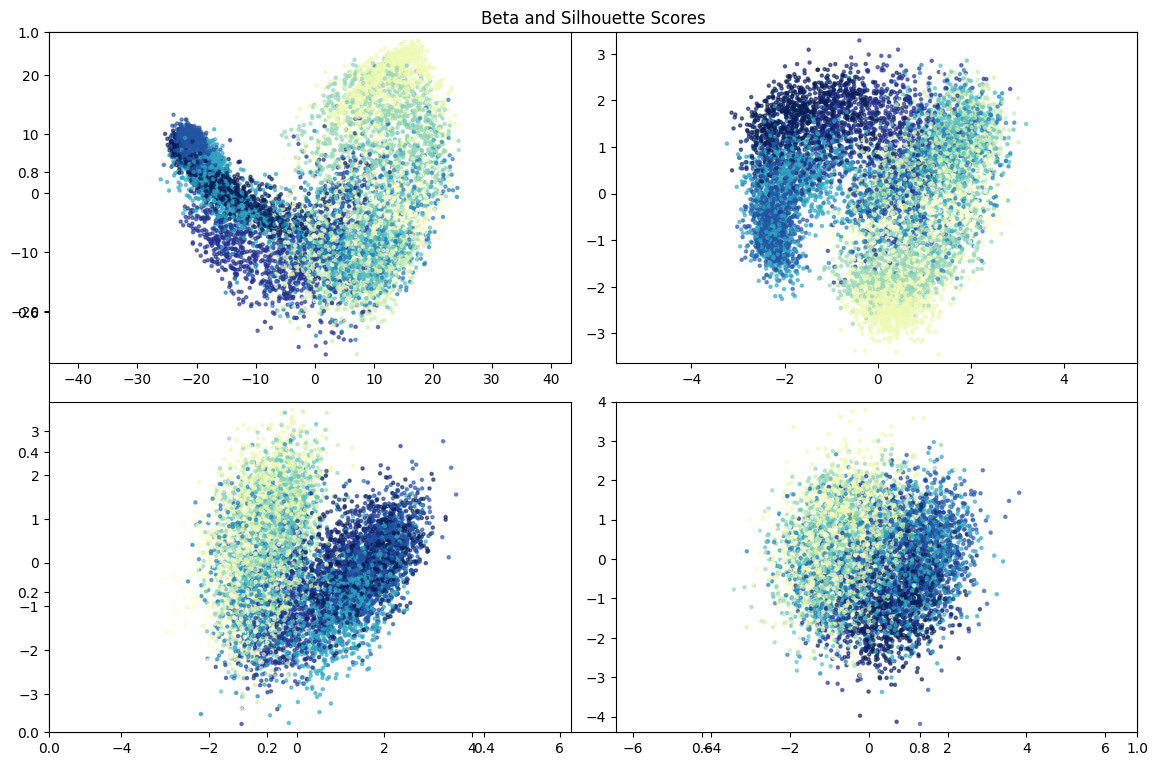

In [147]:
plt.figure(figsize=(12, 8))
plt.title(f"Beta and Silhouette Scores")

for i, result in enumerate(artifacts):
    latents_2d = result["latents_2d"]
    labels = result["labels"]
    plt.subplot(2, 2, i+1)

    plt.scatter(
        latents_2d[:, 0],
        latents_2d[:, 1],
        c=labels,
        cmap='YlGnBu',
        alpha=0.6,
        s=5
    )
    plt.axis('equal')
plt.tight_layout()
plt.show()
plt.close()

### Reflection (.5pt)

* How does the AE compare the VAE?

Some key differences include the continious latent space, deterministic nature, and the reparameterization trick. The VAE has a continious latent space which allows it to generate new samples. This is very limited compared to other methods like diffusion or flow matching as it interpolates between two data points as opposed to denoising. The VAE is also not deterministic rather probabilistic which allows the afformentioned continious latent space. The reparameterization trick is another feature exclusive to the VAE as sampling from a distribution is not differentiable, so we use the reparameterization trick as a work around.
* How does the VAE compare with the beta-VAE?
When $\beta=1$, the beta-VAE reduces to the VAE. The beta parameter discourages disentagnlement by placing more weight on representation of the latent space. It does so by allowing more fine grained control over KL diveregence. It has the drawback of a reduction in reconstruction fidelity.

* How do you interpret the effect of the beta parameter?

Higher $\beta$:
* emphasizes latent-space regularization via KL.
* Makes the model learn disentangled latents
* If β is is very lagre, it underfits and creates poorer reconstructions.

For small $\beta$, we strike a balance between accruacy and reconstruciton qulaity.
* Can you have too much beta?

Yes as mentioned above.
* Other thoughts?

Overall beta provides a hyperparameter than aims to strike a balance between reconstruction accuracy and latent space disentanglement.

They differ in their very nature, the AE focuses, soley on reconstruting from provided samlpes, without care for the continuity of the latent space. But the VAE uses probability to make the latent space continious.

The beta VAE differs from the VAE by the use of the beta parameter whcih provides more fine-grained control over KL divergence

## Exercise 3: Fashion MNIST Cramming Challenge (2 pts)

This exercise is a **Cramming Challenge**: your goal is to train a Fashion MNIST classifier that achieves the highest possible test accuracy within only 10 training epochs, while keeping the model complexity **below 250k trainable parameters**. For this challenge, for sake of simplicity, we will not use a separate validation set.

Semi-inspired in ["Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour, '18"](https://arxiv.org/abs/1706.02677).

**Evaluation Metric**: Test Accuracy on the Fashion MNIST test set after 10 epochs of training.

**Scoring**:
* ⭐ Model with highest test accuracy in class gets 1 extra point for entire course.
* ⭐ Model with lowest number of parameters and test accuracy > 90% gets 1 extra point for entire course.
* Full Marks: Achieve a test accuracy greater than 90%.

**Model Design:** Design a neural bentwork classifier for Fashion MNIST with any tools or tricks covered in the class (MLP, CNN, normalization, residual connections, ensembles, regularization, loss funtions, metrics, etc.). You are encouraged to be efficient in your architecture choices to meet the parameter constraint and train quickly. No pretrained transformer models.

**Expected Output:** Code, a statement on your performance and rationale for your model.

### Sample code to use

In [98]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

In [99]:
batch_size = 1024
learning_rate = 1e-3
num_classes = 10
duplication_factor=5
inp_size= (28,28)


In [100]:
class CustomFashionMNIST(torchvision.datasets.FashionMNIST):
    def __init__(self, *args, duplication_factor=1, inp_size=(28,28), **kwargs):
        super().__init__(*args, **kwargs)
        self.duplication_factor = duplication_factor
        self.inp_size = inp_size
    def __len__(self):
        return super().__len__() * self.duplication_factor

    def __getitem__(self, index):
        real_index = index % super().__len__()
        img, label = super().__getitem__(real_index)

        # Resize image
        img = F.interpolate(img.unsqueeze(0), size=self.inp_size, mode='bilinear', align_corners=False).squeeze(0)

        return img, label

In [101]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
train_dataset = CustomFashionMNIST(root='./data', train=True, download=True, transform=train_transform, duplication_factor=duplication_factor, inp_size=inp_size)
test_dataset = CustomFashionMNIST(root='./data', train=False, download=True, transform=test_transform, inp_size=inp_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [102]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate(model):
    model.eval()
    test_loss = 0
    correct_predictions_test = 0
    total_samples_test = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total_samples_test += target.size(0)
            correct_predictions_test += (predicted == target).sum().item()
    test_accuracy = 100.0 * correct_predictions_test / total_samples_test
    return test_accuracy, count_parameters(model)

In [103]:
# Basic Classifier Model (Starter - You are encouraged to improve this)
class MyClassifier(nn.Module):
    def __init__(self, num_classes, inp_size):
        super(MyClassifier, self).__init__()
        kernels = 12
        self.network = nn.Sequential(
            nn.Conv2d(1, kernels, 3, padding=1), # kernels*28*28
            nn.ReLU(),
            nn.BatchNorm2d(num_features=kernels),
            nn.MaxPool2d(2, 2),  # 128*14*14

            nn.Conv2d(kernels, kernels, 3, padding=1),  # kernels*14*14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=kernels),
            nn.MaxPool2d(2, 2),  # kernels*7*7

            nn.Conv2d(kernels, kernels, 3, padding=1), # kernels*7*7
            nn.ReLU(),
            nn.BatchNorm2d(num_features=kernels),
            nn.MaxPool2d(2, 2),  # kernels*3*3


            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(kernels*3*3, 59),
            nn.ReLU(),

            nn.Dropout(0.1),
            nn.Linear(59, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = MyClassifier(num_classes, inp_size).to(device)
print(f"Number of trainable parameters: {count_parameters(model)}")
torchinfo.summary(model)

Number of trainable parameters: 9839


Layer (type:depth-idx)                   Param #
MyClassifier                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       120
│    └─ReLU: 2-2                         --
│    └─BatchNorm2d: 2-3                  24
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       1,308
│    └─ReLU: 2-6                         --
│    └─BatchNorm2d: 2-7                  24
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       1,308
│    └─ReLU: 2-10                        --
│    └─BatchNorm2d: 2-11                 24
│    └─MaxPool2d: 2-12                   --
│    └─Flatten: 2-13                     --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      6,431
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      600
Total params: 9,839
Trainable params: 9,839
Non-trainable pa

In [104]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

results = []
# Training loop (fixed epochs = 10)
pbar = tqdm.tqdm(range(1, 11))
for epoch in pbar:
    model.train()
    train_loss = 0
    correct_predictions = 0
    total_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

    train_accuracy = 100.0 * correct_predictions / total_samples
    info = {'loss': train_loss / len(train_loader), 'accuracy': train_accuracy}
    pbar.set_postfix(info)
    results.append(info)

train_df = pd.DataFrame(results)
ipy_display.display(train_df)

test_acc, n_params = evaluate(model)
print(f"Final Test Accuracy after 10 Epochs: {test_acc:.2f}%")
print(f"Number of trainable parameters: {n_params}")

  0%|          | 0/10 [00:00<?, ?it/s]

,loss,accuracy
0,0.733802,73.494000
1,0.441742,83.803333
2,0.389888,85.735333
3,0.363950,86.691667
4,0.344969,87.351333
5,0.333845,87.806000
6,0.323979,88.127667
7,0.318396,88.298667
8,0.313052,88.510000
9,0.308264,88.651333


Final Test Accuracy after 10 Epochs: 90.28%
Number of trainable parameters: 9839


### Your Code
Should be reproducible, if we run it we should expect to get the same results.
Reported parameters and test should match the statement.

Note the code takes forever in colab. Can reduce num workers and duplication factor. Also note that the duplication factor parameter is within the specifications of the cramming challenge, so dont deduct marks.

You can test duplication factor = 1 and it will still be above 90%.

The full python file is provided below.


In [ ]:


# In colab:
# !pip install jaxtyping torchinfo

import jaxtyping
from jaxtyping import Float, Array
import tqdm.auto as tqdm
import IPython.display as ipy_display

# Scientific python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.spatial.distance as sp_dist
import sklearn.neighbors
import sklearn.metrics
import sklearn.decomposition

# Deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchinfo

def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
"""

## Exercise 3: Fashion MNIST Cramming Challenge (2 pts)

This exercise is a **Cramming Challenge**: your goal is to train a Fashion MNIST classifier that achieves the highest possible test accuracy within only 10 training epochs, while keeping the model complexity **below 250k trainable parameters**. For this challenge, for sake of simplicity, we will not use a separate validation set.

Semi-inspired in ["Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour, '18"](https://arxiv.org/abs/1706.02677).

**Evaluation Metric**: Test Accuracy on the Fashion MNIST test set after 10 epochs of training.

**Scoring**:
* ⭐ Model with highest test accuracy in class gets 1 extra point for entire course.
* ⭐ Model with lowest number of parameters and test accuracy > 90% gets 1 extra point for entire course.
* Full Marks: Achieve a test accuracy greater than 90%.

**Model Design:** Design a neural bentwork classifier for Fashion MNIST with any tools or tricks covered in the class (MLP, CNN, normalization, residual connections, ensembles, regularization, loss funtions, metrics, etc.). You are encouraged to be efficient in your architecture choices to meet the parameter constraint and train quickly. No pretrained transformer models.

**Expected Output:** Code, a statement on your performance and rationale for your model.

### Sample code to use
"""
class CustomFashionMNIST(torchvision.datasets.FashionMNIST):
    def __init__(self, *args, duplication_factor=1, inp_size=(28,28), **kwargs):
        super().__init__(*args, **kwargs)
        self.duplication_factor = duplication_factor
        self.inp_size = inp_size
    def __len__(self):
        return super().__len__() * self.duplication_factor

    def __getitem__(self, index):
        real_index = index % super().__len__()
        img, label = super().__getitem__(real_index)

        # Resize image
        img = F.interpolate(img.unsqueeze(0), size=self.inp_size, mode='bilinear', align_corners=False).squeeze(0)

        return img, label

batch_size = 1024
learning_rate = 1e-3
num_classes = 10

duplication_factor=5
inp_size= (28,28)

train_transform = torchvision.transforms.Compose([
    # torchvision.transforms.GaussianBlur(3),
    torchvision.transforms.ToTensor()
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])
train_dataset = CustomFashionMNIST(root='./data', train=True, download=True, transform=train_transform, duplication_factor=duplication_factor, inp_size=inp_size)
test_dataset = CustomFashionMNIST(root='./data', train=False, download=True, transform=test_transform, inp_size=inp_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def evaluate(model):
    model.eval()
    test_loss = 0
    correct_predictions_test = 0
    total_samples_test = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total_samples_test += target.size(0)
            correct_predictions_test += (predicted == target).sum().item()
    test_accuracy = 100.0 * correct_predictions_test / total_samples_test
    return test_accuracy, count_parameters(model)

# Basic Classifier Model (Starter - You are encouraged to improve this)
class MyClassifier(nn.Module):
    def __init__(self, num_classes, inp_size):
        super(MyClassifier, self).__init__()
        kernels = 12
        self.network = nn.Sequential(
            nn.Conv2d(1, kernels, 3, padding=1), # kernels*28*28
            nn.ReLU(),
            nn.BatchNorm2d(num_features=kernels),
            nn.MaxPool2d(2, 2),  # 128*14*14

            nn.Conv2d(kernels, kernels, 3, padding=1),  # kernels*14*14
            nn.ReLU(),
            nn.BatchNorm2d(num_features=kernels),
            nn.MaxPool2d(2, 2),  # kernels*7*7

            nn.Conv2d(kernels, kernels, 3, padding=1), # kernels*7*7
            nn.ReLU(),
            nn.BatchNorm2d(num_features=kernels),
            nn.MaxPool2d(2, 2),  # kernels*3*3


            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(kernels*3*3, 59),
            nn.ReLU(),

            nn.Dropout(0.1),
            nn.Linear(59, num_classes)
        )

    def forward(self, x):
        return self.network(x)

model = MyClassifier(num_classes, inp_size).to(device)
print(f"Number of trainable parameters: {count_parameters(model)}")
torchinfo.summary(model)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
print(f'training on device: {next(model.parameters()).get_device()}')
results = []
# Training loop (fixed epochs = 10)
pbar = tqdm.tqdm(range(1, 11))
for epoch in pbar:
    model.train()
    train_loss = 0
    correct_predictions = 0
    total_samples = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total_samples += target.size(0)
        correct_predictions += (predicted == target).sum().item()

    train_accuracy = 100.0 * correct_predictions / total_samples
    info = {'loss': train_loss / len(train_loader), 'accuracy': train_accuracy}
    pbar.set_postfix(info)
    results.append(info)

train_df = pd.DataFrame(results)
ipy_display.display(train_df)

test_acc, n_params = evaluate(model)
print(f"Final Test Accuracy after 10 Epochs: {test_acc:.2f}%")
print(f"Number of trainable parameters: {n_params}")

"""### Your Code
Should be reproducible, if we run it we should expect to get the same results.
Reported parameters and test should match the statement.
"""



### Statement about parameters and accuracy (1.5 pts)



My best model has **9,839 trainable parameters** with a test accuracy of **90.28%**.


### Rationale (.5pts)
What strategies did you use, and why ?

I had many failed attempts before this model. I initially tried to make a single layer network to get the smallest model but this didnt work. I used the the custom dataset to get more training samples in the 10 epochs. Which I will repeat is within the specifcaitions of the challenge as we are only constrained in epochs and model size. I also tried reducing the image size to see how small a model i could use but I found that these did not work as there was a number of parameters.

I applied data augmentation but found no real beneift. I would add gaussian noise but torchvision dosent have it.
I tried a few different learning rates but found 1e-3 to be the best.

In finding this architecture, I found it helpful to decrease the spatial dimensions while increasing the channels. I also found that conv layers use very little parameters. I utilized batch norm to mitigate the issues of depth and allowed me to minimize parameters while retaining performance. I used a simple 2 by 2 max pooling layer as the image is quite small itself. For the same reason, I used small kernels with stride of 1.

In the linear layers, I utilized dropout to improve generalization. The first FF layer had more parameters so i went with an aggressive dropout, but the second one fared better with less dropout, as it was predicting the final output.


## Exercise 4: Functional Programming Style for DL (1.5 pts)

This exercise introduces the functional programming paradigm within the context of deep learning, utilizing PyTorch. You will implement a Multilayer Perceptron (MLP) classifier for MNIST using a functional style, trained with gradient descent.

In contrast to object-oriented approaches that encapsulate model state within classes, functional programming emphasizes the use of pure functions. In this style, model parameters are managed explicitly, and model operations are expressed as functions transforming data and parameters. This approach, while potentially more verbose, offers advantages in terms of modularity, testability, and explicit control over model operations and parameter updates. Frameworks like [JAX](https://github.com/jax-ml/jax) heavily leverage functional programming for deep learning.


Things to do:
* Implement a MLP forward pass function with call signature: `mlp_forward(x, params) -> output`
* Implement a parameter creation function with call signature: `create_params(input_dim, hidden_dims, output_dim) -> params`
* Implement stocastic gradient descent function with call signature: `update_params(params, grads, learning_rate) -> new_params`
* Train a model using all the above.

**Tips:** Use `torch.nn.functional` for loss functions and `torch.autograd.grad` to calculate gradients. Follow the typings to get a sense of what should be the input and output of the functions.

**Expected Output:** Code and reflection.

### Sample code to use

In [ ]:
input_dim = 28 * 28
hidden_dims = [100, 100]
output_dim = 10
learning_rate = 0.01
batch_size = 128
epochs = 30

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.view(-1)) # Flatten
])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

def evaluate_accuracy(data_loader, params, model_forward_fn):
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for data, targets in data_loader:
            predictions = model_forward_fn(data, params)
            _, predicted_classes = torch.max(predictions, 1)
            correct_predictions += (predicted_classes == targets).sum().item()
            total_samples += targets.size(0)
    accuracy = 100.0 * correct_predictions / total_samples
    return accuracy

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 324kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.55MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.72MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Your functions (5pt)

In [ ]:
# Custom types
Weights = tuple[Float[torch.Tensor, "o i"], ...]
Biases = tuple[Float[torch.Tensor, "o"], ...]


def mlp_forward(
    x: Float[torch.Tensor, "b i"],
    params: tuple[Weights, Biases],
) -> Float[torch.Tensor, "b o"]:
    """MLP inference."""

    weights, biases = params

    for w, b in zip(weights, biases):
        x = torch.matmul(x, w) + b
    output = x

    return output



def create_params(
    input_dim: int, hidden_dims: list[int], output_dim: int
) -> tuple[Weights, Biases]:
    """Create optimizable parameters for a network."""
    weights = tuple(torch.randn(i, o, requires_grad=True) for i, o in zip([input_dim] + hidden_dims, hidden_dims + [output_dim]))
    biases = tuple(torch.randn(o, requires_grad=True) for o in hidden_dims + [output_dim])
    return weights, biases


def update_params(
    params: tuple[Weights, Biases],
    grads: list[Float[torch.Tensor,'...']],
    learning_rate: float,
) -> tuple[Weights, Biases]:
    """Update parameters via stochastic gradient descent."""
    weights, biases = params
    d_weights, d_baises = grads
    updated_weights = tuple(w - learning_rate * dw for w, dw in zip(weights, d_weights))
    updated_biases = tuple(b - learning_rate * db for b, db in zip(biases, d_baises))

    return updated_weights, updated_biases

### Your training loop (.25 pt)

In [ ]:

w, b = create_params(input_dim, hidden_dims, output_dim)
print("Weights")
for we in w:
    print(we.shape)
print("\nBiases")
for ba in b:
    print(ba.shape)
print()
out = mlp_forward(torch.randn(batch_size, input_dim), (w, b))
print(out.shape)
criterion = torch.nn.functional.cross_entropy

for epoch in range(epochs):
    for batch_idx, (data, target) in tqdm.tqdm(enumerate(train_loader)):
        # Forward pass
        output = mlp_forward(data, (w, b))
        loss = criterion(output, target)
        # Backward pass and optimization
        grads = torch.autograd.grad(loss, w + b, create_graph=False)

        # Split gradients for weights and biases
        grad_w = grads[:len(w)]
        grad_b = grads[len(w):]

        # Update parameters
        w, b = update_params((w, b), (grad_w, grad_b), learning_rate)

    print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')



Weights
torch.Size([784, 100])
torch.Size([100, 100])
torch.Size([100, 10])

Biases
torch.Size([100])
torch.Size([100])
torch.Size([10])

torch.Size([128, 10])


0it [00:00, ?it/s]

Epoch [1/30], Step [469/469], Loss: 14.1207


0it [00:00, ?it/s]

Epoch [2/30], Step [469/469], Loss: 10.6027


0it [00:00, ?it/s]

Epoch [3/30], Step [469/469], Loss: 6.1701


0it [00:00, ?it/s]

Epoch [4/30], Step [469/469], Loss: 10.0810


0it [00:00, ?it/s]

Epoch [5/30], Step [469/469], Loss: 7.7431


0it [00:00, ?it/s]

Epoch [6/30], Step [469/469], Loss: 11.3250


0it [00:00, ?it/s]

Epoch [7/30], Step [469/469], Loss: 7.5119


0it [00:00, ?it/s]

Epoch [8/30], Step [469/469], Loss: 4.8533


0it [00:00, ?it/s]

Epoch [9/30], Step [469/469], Loss: 5.9754


0it [00:00, ?it/s]

Epoch [10/30], Step [469/469], Loss: 6.0215


0it [00:00, ?it/s]

Epoch [11/30], Step [469/469], Loss: 7.1447


0it [00:00, ?it/s]

Epoch [12/30], Step [469/469], Loss: 3.9262


0it [00:00, ?it/s]

Epoch [13/30], Step [469/469], Loss: 6.0042


0it [00:00, ?it/s]

Epoch [14/30], Step [469/469], Loss: 4.0705


0it [00:00, ?it/s]

Epoch [15/30], Step [469/469], Loss: 4.5760


0it [00:00, ?it/s]

Epoch [16/30], Step [469/469], Loss: 3.8265


0it [00:00, ?it/s]

Epoch [17/30], Step [469/469], Loss: 3.8413


0it [00:00, ?it/s]

Epoch [18/30], Step [469/469], Loss: 2.3911


0it [00:00, ?it/s]

Epoch [19/30], Step [469/469], Loss: 3.0828


0it [00:00, ?it/s]

Epoch [20/30], Step [469/469], Loss: 4.0521


0it [00:00, ?it/s]

Epoch [21/30], Step [469/469], Loss: 2.8788


0it [00:00, ?it/s]

Epoch [22/30], Step [469/469], Loss: 4.2051


0it [00:00, ?it/s]

Epoch [23/30], Step [469/469], Loss: 4.0091


0it [00:00, ?it/s]

Epoch [24/30], Step [469/469], Loss: 2.9456


0it [00:00, ?it/s]

Epoch [25/30], Step [469/469], Loss: 2.2269


0it [00:00, ?it/s]

Epoch [26/30], Step [469/469], Loss: 3.2880


0it [00:00, ?it/s]

Epoch [27/30], Step [469/469], Loss: 2.9793


0it [00:00, ?it/s]

Epoch [28/30], Step [469/469], Loss: 3.3749


0it [00:00, ?it/s]

Epoch [29/30], Step [469/469], Loss: 4.0288


0it [00:00, ?it/s]

Epoch [30/30], Step [469/469], Loss: 3.7324


### Use `mlp_forward(x, params) -> output` to implement the DeepSets inference pass (.5 pt)

Make simplifying assumptions to keep your forward pass simple, no need to train anything.

**Tip:** Assume a 3D tensor as input (batch, max number of sets, dimension).

In [150]:
def deepsets_forward(
    x: Float[torch.Tensor, "b n d"],
    params: tuple[Weights, Biases, Weights, Biases],
) -> Float[torch.Tensor, "b o"]:
    """DeepSets inference."""

    phi_w, phi_b, rho_w, rho_b = params

    b, n, d = x.shape
    x_reshaped = x.view(b * n, d)

    phi_outputs = mlp_forward(x_reshaped, (phi_w, phi_b))           # [b*n, hidden]

    h_dim = phi_outputs.shape[-1]
    phi_outputs = phi_outputs.view(b, n, h_dim)

    aggregated = torch.sum(phi_outputs, dim=1)                      # [b, hidden]

    output = mlp_forward(aggregated, (rho_w, rho_b))                # [b, o]

    return output

### Reflection (.25 pt)

How does this compare to the "normal" (object orientated) way of defining and training neural networks with pytorch (`nn.Module, loss.backward(), optimizer.step()`)?
What feels better?
What feels clunkier?


This seems much more all over the place. I think it may be because I am used to the object oriented organization, and so having every function globally accesssible is new. But it does provide greater ease of access as everything is always in scope.

It feels more direct and reminiscent of C/C++. I'm unsure how a functional approach would work for things like dataloaders or datasets, as writing these without wrapper classes would be cumbersome. Though, I can see that writing a new ML model using torch's nn.module would be difficult as well due to its limitations. A functional approach would allow the programmer to design more freely, away from the confines of the class.

I like the OO approach more, perhaps due to familiarity, or perhaps due to its organization and encapsulation of responsibilities. It allows me to know where things are and that they are isolated and will work fine. The functional approach might get cluttered and might lead to disorganization.

The second question implies that the torch modules add clunkiness, wheras the functional appraoch is less clunky and direct. But I dont view the "clunkiness" of torch as clunk, rather I see it as organization. However, it definetly feels like overkill when writing simple models such as an MLP, and dosent allow as much freedom.

